In [561]:
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels

In [562]:
# Visualize transaction data with pandas dataframe
transaction_data = pd.read_csv("data_set/SAKI - Exercise 1 - Transaction Classification - Data Set.csv",
                               sep=';', index_col=0)
transaction_data

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure
...,...,...,...,...,...,...,...,...,...,...,...
204,NaN,15.02.2016,15.02.2016,Mieteinnahmen,Mietzuschuss End-To-End-Ref.: Notprovided Kund...,Isabel Anna,DE31251900019736000780,VOHADE2HXXX,200.00,EUR,finance
205,NaN,02.02.2016,02.02.2016,Geldanlage,Ccbade31Xxx De71310108339900123456 Sparen End-...,Michael Koffer,DE69790800529736000780,DRESDEFF790,-300.00,EUR,finance
206,NaN,28.01.2016,28.01.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
207,NaN,28.01.2016,28.01.2016,Geldanlage,Ssknde77Xxx De41760501010012345675 Einmalspare...,Christina Jung,DE31251900019736333780,VOHADE2HXXX,-4000.00,EUR,finance


In [631]:
# Concatenate relevant features into unified string 'x'
# Assign label feature to 'y'
x = transaction_data["Buchungstext"] + transaction_data["Verwendungszweck"]
+ transaction_data["Beguenstigter/Zahlungspflichtiger"]
y = transaction_data.label

In [564]:
# Determine train and test set sizes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

In [626]:
# Handle special characters in german language to make stopwords consistent
german_stop_words = stopwords.words("german")
def special_characters(text):
    temp_var = word
    
    temp_var = temp_var.replace('ä', 'ae')
    temp_var = temp_var.replace('ö', 'oe')
    temp_var = temp_var.replace('ü', 'ue')
    temp_var = temp_var.replace('Ä', 'Ae')
    temp_var = temp_var.replace('Ö', 'Oe')
    temp_var = temp_var.replace('Ü', 'Ue')
    temp_var = temp_var.replace('ß', 'ss')
    
    return temp_var

In [627]:
# List to transfer german words to after conversion
german_stop_words_to_use = []
for word in german_stop_words:
    german_stop_words_to_use.append(special_characters(word))

In [632]:
# Perform data preprocessing steps such as strings to tokens, ngrams, and filtering of stopwords
vectorizer = CountVectorizer(lowercase=True, stop_words=german_stop_words_to_use ,strip_accents="unicode"
                             , ngram_range=(1,2))
vectorizer.fit(x_train)

count_x_train = vectorizer.transform(x_train).toarray()
count_x_test = vectorizer.transform(x_test).toarray()

In [621]:
# Declare Gaussian Naive Bayes as classifier
classifier = GaussianNB()

# Fit classifier to training vectors
classifier.fit(count_x_train, y_train)

GaussianNB()

In [622]:
# Predict and print classifier's accuracy
y_predicted = classifier.predict(count_x_test)
print(f"The accuracy of transactions classified is {accuracy_score(y_test, y_predicted)}")

The accuracy of transactions classified is 0.9206349206349206


In [633]:
# Create pipeline to to automate data transformation and classification workflow
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(lowercase=True, stop_words=german_stop_words_to_use, strip_accents="unicode",
                                   ngram_range=(1,2))),
    ("to_dense", FunctionTransformer(lambda n: n.todense())),
    ("classifier", GaussianNB())])

In [624]:
# Utilize cross validation to print classifier accuracy for 10 iterations
cross_validate(pipeline, x, y, scoring="accuracy", cv=10)["test_score"]

array([0.9047619 , 0.95238095, 0.95238095, 0.71428571, 0.95238095,
       0.76190476, 0.80952381, 0.9047619 , 1.        , 1.        ])

In [625]:
# Print classification report statistics
print(classification_report(y_test, y_predicted))

                  precision    recall  f1-score   support

         finance       1.00      0.88      0.93         8
          income       1.00      1.00      1.00         5
         leisure       0.82      0.93      0.87        15
          living       0.90      0.82      0.86        11
         private       0.88      1.00      0.93         7
standardOfLiving       1.00      0.94      0.97        17

        accuracy                           0.92        63
       macro avg       0.93      0.93      0.93        63
    weighted avg       0.93      0.92      0.92        63



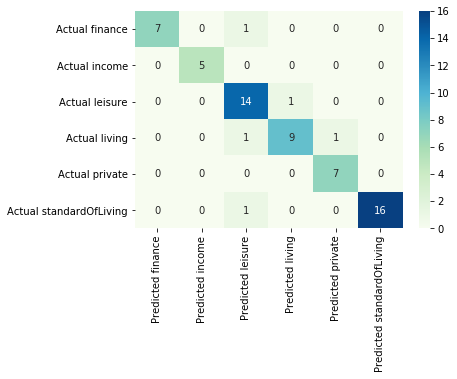

In [617]:
# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_test, y_predicted):
    labels = unique_labels(y_test)
    column = [f"Predicted {label}" for label in labels]
    indices = [f"Actual {label}" for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test, y_predicted),
                        columns=column, index=indices)
    
    return sns.heatmap(table, annot=True, cmap="GnBu")

plot_confusion_matrix(y_test, y_predicted);